### Test for fitting the HB data

###### written by Nicola Pastorello 28/10/2015

In [28]:
%matplotlib inline
# Loading libraries
import numpy as np
import pandas as pd
import datetime, pickle
import os, glob, sys
from pylab import *
from scipy import signal, misc, optimize

In [150]:
# Functions
def functLinesStep(inputPars, xr, numberLines): #Function with sequential lines (not contiguous)
    mvalues, qvalues, breakPoints = (inputPars[:numberLines], 
                                     inputPars[numberLines:numberLines+3], 
                                     inputPars[-numberLines+1:])
    #
    if (len(mvalues)!=numberLines) or (len(qvalues)!=numberLines):
        print "Number of parameters not matching"
        return False
    #
    # Select different regions
    regions = retrieveSelection(xr, breakPoints)
    #
    yy = np.empty(len(xr))
    for ii in np.arange(len(regions)):
        selection = regions[ii][0]
        yy[selection] = mvalues[ii]*xr[selection]+qvalues[ii]
    return yy
# Example
# xx = np.arange(1400)
# yy = functLinesStep(xx, [0, 0.5, -0.2, 0.1], [1,2,5.,-2], [250, 800, 1200])
# plot(xx,yy)

def measure_chi2_Lines(inputPars, xx, yy, numberLines):
    yy_model = functLinesStep(inputPars, xx, numberLines)
    chi2 = Chi2(yy, yy_model)
    return chi2

def Chi2(values, model, errors=nan):
    if not(errors):
        errors = np.ones(len(values))
    sel = np.nonzero(model)
    return np.sum((values[sel]-model[sel])**2./abs(model[sel]))


def retrieveSelection(xx, breaks):
    selections = []
    selections.append(np.where(xx<breaks[0]))
    for ii in np.arange(len(breaks)-1):
        selections.append(np.where((xx>=breaks[ii]) & (xx<breaks[ii+1])))
    selections.append(np.where(xx>breaks[-1]))
    return selections

In [155]:
# Retrieve data
fileIn = open('dicDF.dat', 'rb')
dicDF = pickle.load(fileIn)
fileIn.close()

DFtmp = dicDF[dicDF.keys()[123]]

#### Fit of the profile with the multiple-lines approach

In [ ]:
# Initial guesses

xx, yy = np.array(DFtmp.index), np.array(DFtmp['hb'])
guessNightTime = [660, 1080] # Minutes of sleeping time (11pm-6am)
# This can be found more efficiently somehow else (e.g. rolling 
# Gini coefficient, accelerometer std, ...)

                    
        
        
[sel_1, sel_2, sel_3] = retrieveSelection(xx, guessNightTime)

values_line_1 = np.polyfit(xx[sel_1], yy[sel_1], 1)
values_line_2 = np.polyfit(xx[sel_2], yy[sel_2], 1)
values_line_3 = np.polyfit(xx[sel_3], yy[sel_3], 1)


initialGuesses = ([values_line_1[0], values_line_2[0], values_line_3[0],  #m
                   values_line_1[1], values_line_2[1], values_line_3[1], #q
                   700, 1100]) #breaks
numberLines = 3

Optimization terminated successfully.
         Current function value: 897.490704
         Iterations: 1812
         Function evaluations: 2788
  status: 0
    nfev: 2788
 success: True
     fun: 897.49070373124516
       x: array([ -3.21733701e-02,   3.37305924e-02,   5.51383022e-02,
         9.51494587e+01,   3.45566138e+01,   9.32818228e+00,
         6.33998622e+02,   1.10200000e+03])
 message: 'Optimization terminated successfully.'
     nit: 1812


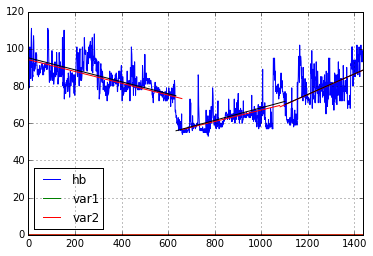

In [156]:
# Pearson's Chi^2 minimization with Nelder-Mead algorithm

solution = optimize.minimize(measure_chi2_Lines, 
                                initialGuesses,
                                args=(xx,yy, numberLines), 
                                method='Nelder-Mead', 
                                options={'disp':True, 
                                         'maxiter':1e5, 'maxfev':1e5})

DFtmp.plot()

plot(xx[sel_1], xx[sel_1]*values_line_1[0]+values_line_1[1], c='r')
plot(xx[sel_2], xx[sel_2]*values_line_2[0]+values_line_2[1], c='r')
plot(xx[sel_3], xx[sel_3]*values_line_3[0]+values_line_3[1], c='r')


# SOLUTION
print solution

[sel_1new, sel_2new, sel_3new] = retrieveSelection(xx, [solution.x[-2], solution.x[-1]])
plot(xx[sel_1new], xx[sel_1new]*solution.x[0]+solution.x[3], c='k')
plot(xx[sel_2new], xx[sel_2new]*solution.x[1]+solution.x[4], c='k')
plot(xx[sel_3new], xx[sel_3new]*solution.x[2]+solution.x[5], c='k')

slice(-0.5, 0.5, 0.1)

In [ ]:
# Fit with multiple lines and extract chi^2 with brute-force algorithm
# Pearson's Chi^2 minimization with Nelder-Mead algorithm

ranges = [slice(-0.5,0.5, 0.1), slice(-0.5,0.5, 0.1), slice(-0.5,0.5, 0.1),
          slice(40,100, 5), slice(40,100, 5), slice(40,100, 5),
          slice(600,720,5), slice(1000,1260,5) 
         ]

solution = optimize.brute(measure_chi2_Lines, 
                          ranges,
                          args=(xx, yy, numberLines),
                          Ns=200 #Number points
                        #,disp=True
                        #,full_output=True
                         )
                           
# DFtmp.plot()

# plot(xx[sel_1], xx[sel_1]*values_line_1[0]+values_line_1[1], c='r')
# plot(xx[sel_2], xx[sel_2]*values_line_2[0]+values_line_2[1], c='r')
# plot(xx[sel_3], xx[sel_3]*values_line_3[0]+values_line_3[1], c='r')


# # SOLUTION
# print solution

# [sel_1new, sel_2new, sel_3new] = retrieveSelection(xx, [solution.x[-2], solution.x[-1]])
# plot(xx[sel_1new], xx[sel_1new]*solution.x[0]+solution.x[3], c='k')
# plot(xx[sel_2new], xx[sel_2new]*solution.x[1]+solution.x[4], c='k')
# plot(xx[sel_3new], xx[sel_3new]*solution.x[2]+solution.x[5], c='k')

In [124]:
solution

  status: 1
    nfev: 100000
 success: False
     fun: 426970.3873590742
       x: array([  0.00000000e+00,  -2.00000000e-01,   0.00000000e+00,
         1.20000000e+02,   1.89000000e+02,   1.20000000e+02,
         5.00000000e+02,   1.20000000e+03])
 message: 'Maximum number of function evaluations has been exceeded.'
     nit: 35609

In [119]:
optimize.show_options(method='Nelder-Mead')


minimize
--------

**Minimize options**

*BFGS* options:

    gtol : float
        Gradient norm must be less than `gtol` before successful
        termination.
    norm : float
        Order of norm (Inf is max, -Inf is min).
    eps : float or ndarray
        If `jac` is approximated, use this value for the step size.

*Nelder-Mead* options:

    xtol : float
        Relative error in solution `xopt` acceptable for convergence.
    ftol : float
        Relative error in ``fun(xopt)`` acceptable for convergence.
    maxfev : int
        Maximum number of function evaluations to make.

*Newton-CG* options:

    xtol : float
        Average relative error in solution `xopt` acceptable for
        convergence.
    eps : float or ndarray
        If `jac` is approximated, use this value for the step size.

*CG* options:

    gtol : float
        Gradient norm must be less than `gtol` before successful
        termination.
    norm : float
        Order of norm (Inf is max, -Inf is min).
 

In [ ]:
# Smooth data and try to fit it again